In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/AD

/content/drive/MyDrive/AD


In [34]:
class Config:
    model_file = "artifacts/MNADrc/Ped2_prediction_model.pth"
    model_keys_file = "artifacts/MNADrc/Ped2_prediction_keys.pt"
    data_dir = "data/ped2/testing/st_frames"
    vid_dir = "data/ped2/testing/videos"
    gt_file = "data/ped2/ped2.mat"
    dataset_type = "ped2"
    desired_folder = "13"
    anomalous_data = False

    gpus = "0"
    h = 256
    w = 256
    t_length = 5
    th = 0.01
    alpha = 0.6
    batch_size = 1
    num_workers_test = 1

## Setting Up (Optional)

In [ ]:
!git clone https://github.com/alchemi5t/MNADrc.git

Cloning into 'MNADrc'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 356 (delta 30), reused 29 (delta 29), pack-reused 318
Receiving objects: 100% (356/356), 1.05 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [ ]:
!unzip tars/Ped2_prediction.zip

Archive:  tars/Ped2_prediction.zip
  inflating: Ped2_prediction_model.pth  
  inflating: Ped2_prediction_keys.pt  


In [ ]:
!ls {Config.data_dir}

02  09.tar.xz  12  13


In [ ]:
!tar -xf {Config.data_dir}/{Config.desired_folder}.tar.xz -C {Config.data_dir}
!rm {Config.data_dir}/{Config.desired_folder}.tar.xz

In [ ]:
# !cd MNADrc && python3 Evaluate_Pred_No_Skip.py --dataset_path ../{Config.DATA_PATH}/ --model_dir ../{Config.MODEL_PATH} --m_items_dir ../{Config.MODEL_KEYS_PATH}

## Imports

In [5]:
import sys
sys.path.append("MNADrc")

In [7]:
import os
import time
import scipy.io
import glob
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import model.utils_pred as utils_pred

from utils import *
from model.Prediction import *


from pathlib import Path
from collections import OrderedDict
import torchvision.transforms as transforms
from torch.autograd import Variable

% matplotlib inline

In [ ]:
from importlib import reload
reload(utils_pred)

<module 'model.utils_pred' from 'MNADrc/model/utils_pred.py'>

## Functions

In [8]:
# torch setup

def torch_setup(config):
    torch.manual_seed(2020)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = config.gpus
    torch.backends.cudnn.enabled = True

In [9]:
# Loading dataset

def get_dataset_batch(config):
    dataset = utils_pred.DataLoader(config.data_dir, 
                         transforms.Compose([
                            transforms.ToTensor()
                            ]),
                         resize_height = config.h, 
                         resize_width = config.w, 
                         time_step = config.t_length - 1,
                         filter_vid_name = config.desired_folder)

    config.dataset_size = len(dataset)

    dataset_batch = data.DataLoader(dataset, 
                              batch_size = config.batch_size, 
                              shuffle = False, 
                              num_workers = config.num_workers_test,
                              drop_last = False)

    return dataset_batch


In [10]:
# load model

def get_model(config):
    model = torch.load(config.model_file)
    model.cuda()
    m_items = torch.load(config.model_keys_file)

    return model, m_items

In [11]:
# load ground truth

def get_gt(config):
    mat = scipy.io.loadmat(config.gt_file)
    gt = mat["gt"][0]
    if config.anomalous_data:
        return gt
    return []

In [12]:
# videos dict

def get_videos(config):
    videos = OrderedDict()
    
    videos_list = sorted(glob.glob(os.path.join(config.data_dir, '*')))
    filtered_videos_list = []
    for video in videos_list:
        video_name = video.split('/')[-1]
        if config.desired_folder and (video_name != config.desired_folder):
            continue
        filtered_videos_list.append(video)
        videos[video_name] = {}
        videos[video_name]['path'] = video
        videos[video_name]['frame'] = glob.glob(os.path.join(video, '*.jpg'))
        videos[video_name]['frame'].sort()
        videos[video_name]['length'] = len(videos[video_name]['frame'])
    return videos, filtered_videos_list

In [13]:
# init data structures

def init_datastructures(config, videos_dict, videos_list, gt, ds):
    psnr_list, feature_dist_list, labels_list = {}, {}, []
    for video in videos_list:
        video_name = video.split('/')[-1]
        if video_name not in videos_dict:
            continue
        video_length = videos_dict[video_name]["length"]
        video_idx = int(video_name) - 1 # assuming video name is like "001", "002" etc
        if video_idx >= len(gt):
            anomaly_start = video_length
            anomaly_end = video_length
        else:
            anomaly_start = gt[video_idx][0].item()
            anomaly_end = gt[video_idx][1].item()
        
        print(f"Video id: {video_idx}, anomaly start: {anomaly_start}, anomaly end: {anomaly_end}")
        
        y_true = [0] * anomaly_start + [1] * (anomaly_end - anomaly_start) + [0] * (video_length - anomaly_end)
        labels_list = np.append(labels_list, y_true[4:])

        psnr_list[video_name] = []
        feature_dist_list[video_name] = []
    
    ds["psnr_list"] = psnr_list
    ds["feature_dist_list"] = feature_dist_list
    ds["labels_list"] = labels_list

In [14]:
# evaluate

def evaluate(config, model, m_items, dataset_batch, videos_dict, videos_list, ds):
    label_length = 0
    video_num = 0
    loss_func_mse = nn.MSELoss(reduction="none")

    label_length += videos_dict[videos_list[video_num].split('/')[-1]]['length']
    m_items_test = m_items.clone()

    model.eval()
    t1 = time.time()

    for k, (imgs) in enumerate(dataset_batch):
        if k == label_length - 4*(video_num+1):
            video_num += 1
            label_length += videos_dict[videos_list[video_num].split('/')[-1]]['length']

        imgs = Variable(imgs).cuda()
        print(f"Running batch: {k}, img_shape: {imgs.shape}")
        
        outputs, feas, updated_feas, m_items_test, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(imgs[:,0:3*4], 
                                                                                                                                        m_items_test, 
                                                                                                                                        False)
        output_img = outputs.cpu().data.numpy()
        output_img = output_img.squeeze(0)
        mse_imgs = torch.mean(loss_func_mse((outputs[0]+1)/2, (imgs[0,3*4:]+1)/2)).item()
        # print(mse_imgs.shape)
        mse_feas = compactness_loss.item()
        # output_img = output_img.squeeze(0)
        output_img = np.transpose(output_img, (1, 2, 0))
        # print(output_img)
        # Path("./viss").mkdir(parents=True, exist_ok=True)
        # cv2.imwrite("./viss/out"+str(k)+".jpg", ((output_img + 1)*127.5).astype(np.uint8))
        
        # # Calculating the threshold for updating at the test time
        point_sc = point_score(outputs, imgs[:,3*4:])

        if  point_sc < config.th:
            query = F.normalize(feas, dim=1)
            query = query.permute(0,2,3,1) # b X h X w X d
            m_items_test = model.memory.update(query, m_items_test, False)
        psnr_dict = {}

        # print(k, psnr(mse_imgs))
        ds["psnr_list"][videos_list[video_num].split('/')[-1]].append(psnr(mse_imgs))
        ds["feature_dist_list"][videos_list[video_num].split('/')[-1]].append(mse_feas)
        
        # return

    t2 = time.time()
    print(f"Elapsed: {(t2 - t1)} secs")

In [15]:
# calc anomaly scores

def get_anomaly_scores(config, videos_list, ds, save=True, plot=True):

    anomaly_score_total_list = []
    for video in sorted(videos_list):
        video_name = video.split('/')[-1]
        anomaly_score_total_list += score_sum(
                                        anomaly_score_list(ds["psnr_list"][video_name]), 
                                        anomaly_score_list_inv(ds["feature_dist_list"][video_name]),
                                        config.alpha
                                    )

    anomaly_score_total_list = np.asarray(anomaly_score_total_list)

    if save:
        df = pd.DataFrame(data=anomaly_score_total_list)
        df.to_csv('file1.csv')
    
    if plot:
        plt.plot(anomaly_score_total_list)
        plt.savefig('graph.png')
        plt.show();
    
    return anomaly_score_total_list

In [16]:
# calc AUC

def calc_AUC(anomaly_score_total_list, ds):
    accuracy = AUC(anomaly_score_total_list, np.expand_dims(1-ds["labels_list"], 0))
    return accuracy

In [17]:
def vid_to_frames(vid_name, out_dir):
    vid_name_wo_ext = Path(vid_name).stem
    frames_dir = Path(out_dir) / vid_name_wo_ext
    frames_dir.mkdir(exist_ok=True, parents=True)
    print(frames_dir)
    cap = cv2.VideoCapture(vid_name)
    idx = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame = cv2.resize(frame, (Config.h, Config.w))
        frame_file = frames_dir / f"{idx:03d}.jpg"
        cv2.imwrite(str(frame_file), frame)
        idx += 1
    
    cap.release()

## Calls

In [62]:
vid_to_frames(os.path.join(Config.vid_dir, f"{Config.desired_folder}.mp4"), "data/ped2/testing/st_frames")

data/ped2/testing/st_frames/13


In [18]:
torch_setup(Config)

In [19]:
model, m_items = get_model(Config)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1.convAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source cod

In [63]:
dataset_batch = get_dataset_batch(Config)

In [64]:
gt = get_gt(Config)

In [65]:
videos_dict, videos_list = get_videos(Config)

In [66]:
ds = {}
init_datastructures(Config, videos_dict, videos_list, gt, ds)

Video id: 12, anomaly start: 180, anomaly end: 180


In [67]:
evaluate(Config, model, m_items, dataset_batch, videos_dict, videos_list, ds)

Running batch: 0, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 1, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 2, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 3, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 4, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 5, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 6, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 7, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 8, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 9, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 10, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 11, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 12, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 13, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 14, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 15, img_shape: torch.Size([1, 15, 256, 256])
Running batch: 16, img_shape: torch.Size([1, 15, 2

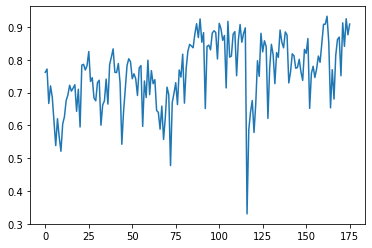

In [68]:
anomaly_score_total_list = get_anomaly_scores(Config, videos_list, ds)


In [ ]:
anomaly_score_total_list

array([0.5471243 , 0.46286394, 0.43745092, 0.49935   , 0.43136194,
       0.2958276 , 0.23989367, 0.41229605, 0.3964129 , 0.29336559,
       0.32545244, 0.47841268, 0.47481877, 0.33470966, 0.47190465,
       0.39463325, 0.39627803, 0.3802617 , 0.37464158, 0.41846439,
       0.43189915, 0.45731348, 0.48038582, 0.44880203, 0.55697453,
       0.51991108, 0.49382445, 0.46709357, 0.42156891, 0.39067392,
       0.43798463, 0.47889316, 0.3283222 , 0.54584085, 0.59875872,
       0.59475734, 0.40443963, 0.5437492 , 0.57131162, 0.62704764,
       0.58520866, 0.57319578, 0.55745874, 0.54842435, 0.48091727,
       0.4905257 , 0.43314897, 0.56328824, 0.58728374, 0.62441082,
       0.61662503, 0.52354847, 0.53208315, 0.51679147, 0.63027902,
       0.52626622, 0.45214379, 0.52167727, 0.57789537, 0.60302959,
       0.44131151, 0.50129297, 0.53009427, 0.54854535, 0.40261999,
       0.36323387, 0.41872224, 0.59219023, 0.4570807 , 0.34650287,
       0.46777709, 0.45694538, 0.39691034, 0.50753141, 0.54568

In [ ]:
if not Config.anomalous_data:
    print("AUC is not defined in this case.")
    AUC_val = "NA"
else:
    try:
        AUC_val = calc_AUC(anomaly_score_total_list, ds)
    except ValueError as err:
        print(err)
        AUC_val = "NA"

AUC_val

AUC is not defined in this case.


'NA'

In [ ]:
gt

array([array([[ 61],
              [180]], dtype=uint8), array([[ 95],
                                           [180]], dtype=uint8),
       array([[  1],
              [146]], dtype=uint8), array([[ 31],
                                           [180]], dtype=uint8),
       array([[  1],
              [129]], dtype=uint8), array([[  1],
                                           [159]], dtype=uint8),
       array([[ 46],
              [180]], dtype=uint8), array([[  1],
                                           [180]], dtype=uint8),
       array([[  1],
              [120]], dtype=uint8), array([[  1],
                                           [150]], dtype=uint8),
       array([[  1],
              [180]], dtype=uint8), array([[ 88],
                                           [180]], dtype=uint8)],
      dtype=object)

## Reconstruction vis

In [ ]:
Config.data_dir

'data/ped2/testing/frames'

In [ ]:
og_img = cv2.imread(Config.data_dir + "/13/004.jpg")
og_img = cv2.resize(og_img, (256, 256))

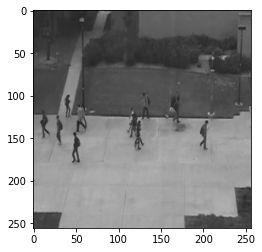

In [ ]:
plt.imshow(og_img);

In [ ]:
og_img2 = cv2.imread("data/ped2/testing/frames" + "/13/004.jpg")
og_img2 = cv2.resize(og_img2, (256, 256))

In [ ]:
recon = cv2.imread("./viss/out0.jpg")

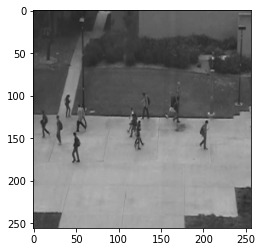

In [ ]:
plt.imshow(og_img2);

In [ ]:
from skimage.metrics import structural_similarity as ssim

In [ ]:
score, diff = ssim(cv2.cvtColor(og_img, cv2.COLOR_RGB2GRAY), cv2.cvtColor(og_img2, cv2.COLOR_RGB2GRAY), full=True)

In [ ]:
diff.shape

(256, 256)

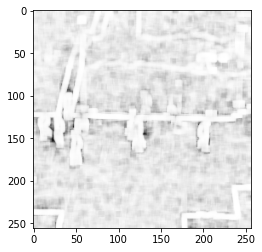

In [ ]:
plt.imshow(diff, cmap="gray");

In [ ]:
thresh = cv2.threshold((diff*255).astype(np.uint8), 230, 255, cv2.THRESH_BINARY_INV)[1]

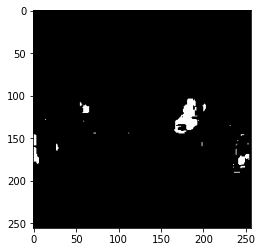

In [ ]:
plt.imshow(thresh, cmap="gray");

In [ ]:
cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
box_list = []                     
loc_coords = 0
c = max(cnts, key = cv2.contourArea)
x,y,w,h = cv2.boundingRect(c)

In [ ]:
x, y, w, h

(166, 104, 27, 41)

In [ ]:
cv2.rectangle(recon,(x,y),(x+w,y+h),(128, 255,0),2);

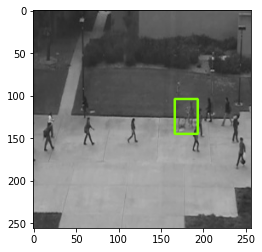

In [ ]:
plt.imshow(recon);

## UI stuff

In [69]:
!pip install -q streamlit pyngrok stqdm

     |████████████████████████████████| 9.1 MB 30.5 MB/s 
     |████████████████████████████████| 745 kB 56.6 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 4.3 MB 61.1 MB/s 
     |████████████████████████████████| 164 kB 68.1 MB/s 
     |████████████████████████████████| 235 kB 73.9 MB/s 
     |████████████████████████████████| 181 kB 70.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 132 kB 72.0 MB/s 
     |████████████████████████████████| 423 kB 5.9 MB/s 
     |████████████████████████████████| 132 kB 77.8 MB/s 
     |████████████████████████████████| 793 kB 57.3 MB/s 
     |████████████████████████████████| 381 kB 72.5 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.6.6 requi

In [74]:
!ngrok authtoken <insert your ngrok auth token here>

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [75]:
from pyngrok import ngrok 
public_url = ngrok.connect(port="8501")
public_url

<NgrokTunnel: "http://39f0-34-143-241-52.ngrok.io" -> "http://localhost:80">

In [ ]:
!cd MNADrc && streamlit run vis_prediction.py & npx localtunnel --port 8501

2022-08-03 14:03:22.225 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.143.241.52:8501

npx: installed 22 in 3.436s
your url is: http://rotten-clubs-stick-34-143-241-52.loca.lt
Starting UI ...
In About section ...
Starting UI ...
In run ...
Starting UI ...
In run ...
Starting UI ...
In run ...
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1.convAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential'